# Self-Driving Car Engineer

## Lucas Gago

## Machine Learning

## Project: Vehicle Detection

In [2]:
import numpy as np
import cv2
import glob
import os
from time import time
import numpy as np
import fnmatch


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.ndimage.measurements import label


from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.gridspec as gridspec
from sklearn.model_selection import StratifiedKFold

from IPython.core.display import Image, display
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

## Functions
---

In [3]:
def calibrate_camera(cal_images, nx, ny):
    
    # Camera calibration
    
    imge=[]
    orig=[]
    objpoints=[]  # 3D points
    imgpoints=[]  # 2D points

    objp=np.zeros((nx*ny,3), np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname=cal_images[0]
    for fname in cal_images:
        img=cv2.imread(fname)
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners=cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            imge.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))
            
    ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist,imge

def camera_setup():
    
    # Camera setup, calibration with files into ./camera_cal
    
    cal_images=glob.glob('camera_cal/calibration*.jpg')
    nx, ny=9, 6
    cam_mtx, cam_dist,imge= calibrate_camera(cal_images, nx, ny)
    
    return cam_mtx, cam_dist,imge

def show_Grid(X,Y,colorx,colory):
    
    # Plotting function
    
    h=len(X)
    w=2
    features_example=[]
    plt.figure(figsize=(10,h*3))
    gs1=gridspec.GridSpec(h,w)
    gs1.update(wspace=0.002, hspace=0.2)
    count=0
    for i in range(h):
        ax1=plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        count+=1
        if colorx:
            plt.imshow(X[i], cmap='gray')
        else:
            plt.imshow(X[i])
        ax1=plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        if colory:
            plt.imshow(Y[i], cmap='gray')
        else:
            plt.imshow(Y[i])
        count+=1
    plt.show()
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Extract HOG features
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def change_color(img,color_space):
    
    # Color space transformation
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: img = np.copy(img)  
        
    return img 

def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Color histogram, concatenated
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Complete function to extact and concatenate features
    
    features = []
    for img in imgs:
        file_features = []
        feature_image=change_color(img,color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

def create_baseline():
    
    # NN model
    
    model = Sequential()
    model.add(Dense(60, input_dim=len(X_train[0]), init='normal', activation='relu'))
    model.add(Dense(30, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def predict_labels_accuracy(clf, features, target):
    
    # Given a clasfier and features, return accuracy
    
    y_pred = clf.predict(features)

    return accuracy_score(target, y_pred)   

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    #Print accuracy
    
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    clf.fit(X_train, y_train)
    print ("Accuracy score for training set: {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
    print ("Accuracy score for test set: {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Given an image and boxes position, draw them
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # Slide window (only between x_start_stop and y_start_stop), with 0,5 of overlap
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # serach in windows, return positive ones
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    
    # Same as img_features, but only for one
    img_features = []
    feature_image=change_color(img,color_space)
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

def process_image(imagen):
    
    # process image with selected parameters, return windows with positives
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 7  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()
    
    windows = slide_window(imagen, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(imagen, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
    return hot_windows

def non_max_suppress(imagen,hot_windows,thres):
    
    # process heat and return labeled boxes

    heat = np.zeros_like(imagen[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,thres) 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    return bbox_from_labels(labels)

def add_heat(heatmap, bbox_list):
    
    # Add value for all pixels inside boxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap
    
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    
    heatmap[heatmap <= threshold] = 0

    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars and draw rectangles in detections
    
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

def bbox_from_labels(labels):
    
    # Return bounding boxes for positives
    
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox) 
        
    return bbox_list


class Processor:
    
    # Class for filtering positives in video
    
    def __init__(self):
        self._frame_index = 0
        self._FRAME_AGGREGATE = 10
        self._detection_list_total = None
        self._bbox_list_recent = None
        self._threshold = 6
        
    
    def _aggregate_detections(self, detections_):
        if self._detection_list_total is None:
            self._detection_list_total = detections_
        else:
            self._detection_list_total.extend(detections_)

    def process_frame(self, image):
        image=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
        detections = process_image(image)
        self._aggregate_detections(detections)
        self._frame_index += 1
        if self._frame_index%self._FRAME_AGGREGATE == 0:
            self._bbox_list_recent = non_max_suppress(image, self._detection_list_total,self._threshold)
            self._detection_list_total = None 
        if self._bbox_list_recent is not None:
            result = draw_boxes(image, self._bbox_list_recent, color=(0, 0, 255), thick=6)
            return result
        else:
            return image
        
        
class ProcessorHaar:
    
    # Class for filtering Haar detections
    
    def __init__(self):
        self._frame_index = 0
        self._FRAME_AGGREGATE = 10
        self._detection_list_total = None
        self._bbox_list_recent = None
        self._threshold = 2
        
    
    def _aggregate_detections(self, detections_):
        if self._detection_list_total is None:
            self._detection_list_total = detections_
        else:
            self._detection_list_total.extend(detections_)

    def process_frame(self, cars,image):
        self._aggregate_detections(cars)
        self._frame_index += 1
        if self._frame_index%self._FRAME_AGGREGATE == 0:
            self._bbox_list_recent = non_max_suppress(image, self._detection_list_total,self._threshold)
            self._detection_list_total = None 
        if self._bbox_list_recent is not None:
            result = draw_boxes(image, self._bbox_list_recent, color=(0, 0, 255), thick=6)
            return result
        else:
            return image

## Camera Calibration

---

In [4]:
cam_mtx, cam_dist,imge= camera_setup()

## Load the dataset
---

In [5]:
cars_data = []
for filename in glob.glob('vehicles/*.png'):
    img=cv2.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cars_data.append(img)
    
non_cars_data = []
for filename in glob.glob('non_vehicles/*.png'):
    img=cv2.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_cars_data.append(img)

## Explore the dataset
---

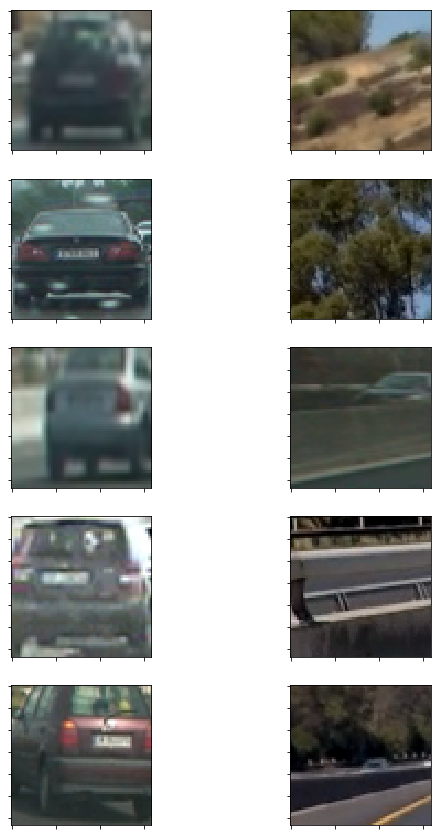

In [7]:
cars_data = shuffle(cars_data)
non_cars_data = shuffle(non_cars_data)
cars_example=[]
non_cars_example=[]
for i in range(5):
    cars_example.append(cars_data[i])
    non_cars_example.append(non_cars_data[i])
    
show_Grid(cars_example,non_cars_example,False,False)

## Explore HOG
---

### Orientation Variation

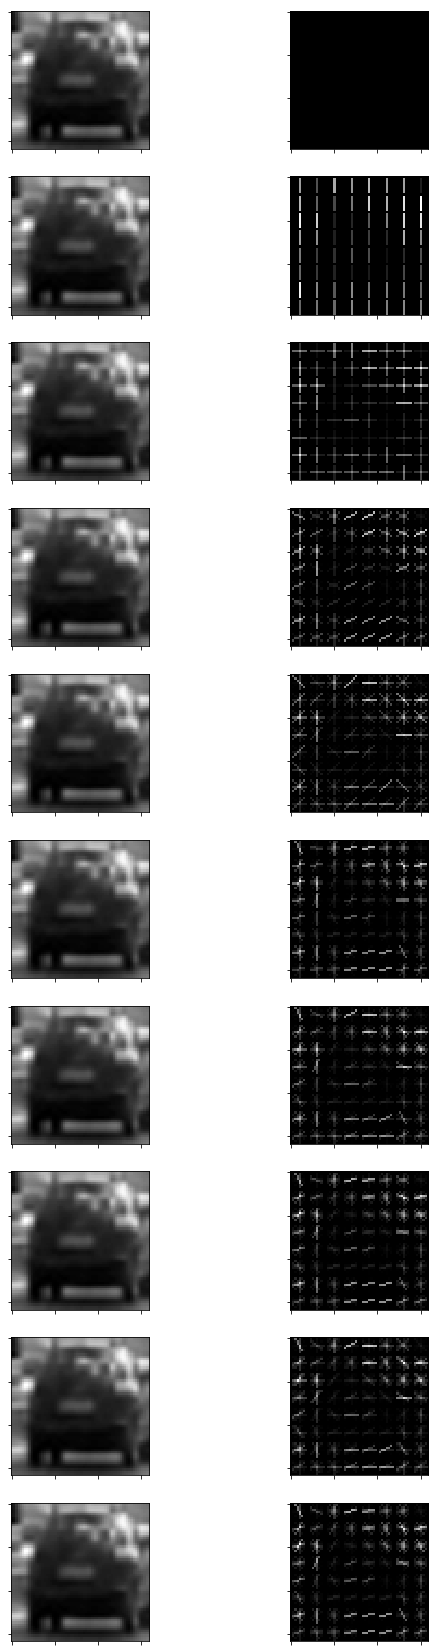

In [9]:
gray = cv2.cvtColor(cars_data[0], cv2.COLOR_RGB2GRAY)

car_example=[]
or_example=[]
for i in range(10):
    orient = i
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    or_example.append(hog_image)
    car_example.append(gray)
    
show_Grid(car_example,or_example,True,True)

### Pixels per cell variation

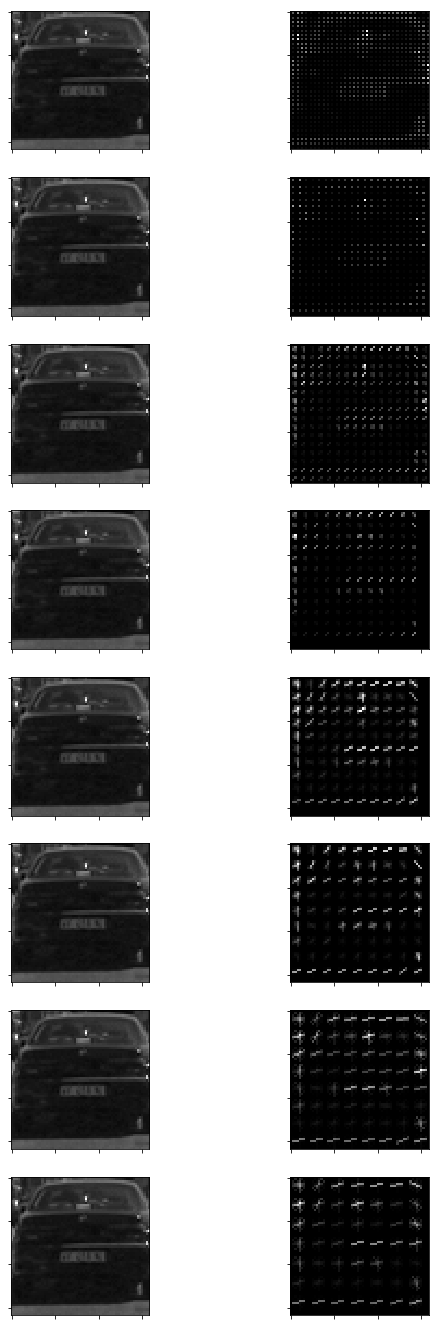

In [10]:
gray = cv2.cvtColor(cars_data[10], cv2.COLOR_RGB2GRAY)

car_example=[]
or_example=[]
for i in range(2,10):
    orient = 7
    pix_per_cell = i
    cell_per_block = 2

    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    or_example.append(hog_image)
    car_example.append(gray)
    
show_Grid(car_example,or_example,True,True)

### Cell per block variation

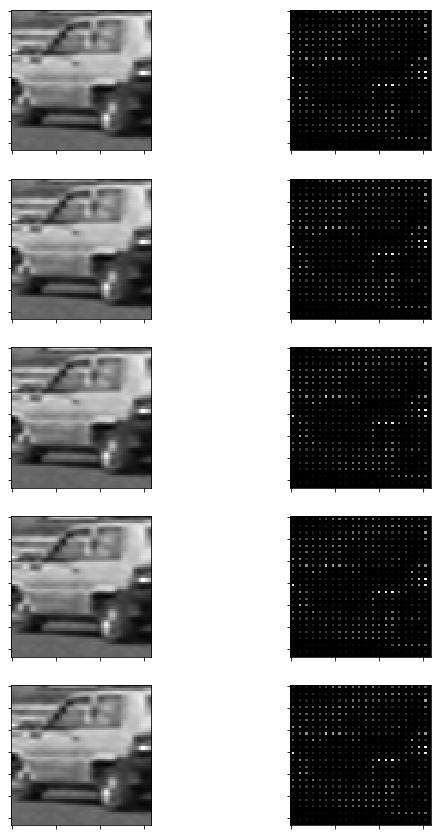

In [11]:
gray = cv2.cvtColor(cars_data[111], cv2.COLOR_RGB2GRAY)

car_example=[]
or_example=[]
for i in range(5):
    orient = 7
    pix_per_cell = 3
    cell_per_block = i*2

    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    or_example.append(hog_image)
    car_example.append(gray)
    
show_Grid(car_example,or_example,True,True)

### Color space variation

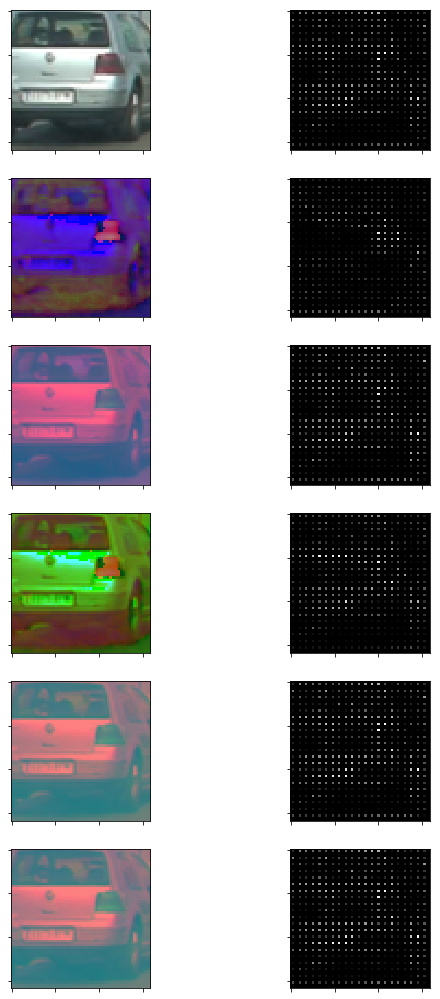

In [15]:
img=cars_data[120]
colorspaces=["RGB","HSV","LUV","HLS","YUV","YCrCb"]
car_example=[]
or_example=[]
for i in colorspaces:
    img_color_changed=change_color(img,i)
    gray = cv2.cvtColor(img_color_changed, cv2.COLOR_RGB2GRAY)
    orient = 7
    pix_per_cell = 3
    cell_per_block = 2

    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    or_example.append(hog_image)
    car_example.append(img_color_changed)
    
show_Grid(car_example,or_example,False,True)

## Selection of best HOG features for classification

In [16]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


sample_size = 2400  # Reduce for better performance
cars= cars_data[0:sample_size]
non_cars = non_cars_data[0:sample_size]

t=time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
t2 = time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()

t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time()

15.19 Seconds to extract HOG features...
Using: 7 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
5.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9958


### Final Parameters

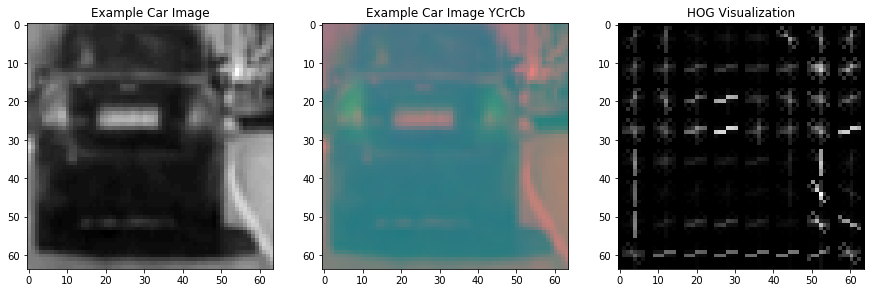

In [19]:
im = cv2.cvtColor(cars_data[490], cv2.COLOR_RGB2YCrCb)
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
orient = 7
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

fig = plt.figure()
plt.figure(figsize=(15,20))

plt.subplot(131)
plt.imshow(gray,cmap='gray')
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(im)
plt.title('Example Car Image YCrCb')
plt.subplot(133)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Check simple NN performance
---

In [48]:
seed = 7
numpy.random.seed(seed)

In [70]:
%%time
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (max(results)*100, results.std()*100))

Results: 99.45% (0.34%)
Wall time: 14min 2s


In [73]:
print("Best Result: %.2f%% (%.2f%%)" % (max(results)*100, results.std()*100))

Best Result: 99.79% (0.34%)


## Try using different ML classifiers
---

In [42]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process","Decision Tree", "Random Forest", "Neural Net", "AdaBoost","Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for clf in classifiers:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for n in [100,2000]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ('-'*32)


KNeighborsClassifier: 

Training a KNeighborsClassifier using a training set size of 100. . .
Accuracy score for training set: 0.9500.
Accuracy score for test set: 0.9021.
--------------------------------
Training a KNeighborsClassifier using a training set size of 2000. . .
Accuracy score for training set: 0.9865.
Accuracy score for test set: 0.9646.
--------------------------------

SVC: 

Training a SVC using a training set size of 100. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9635.
--------------------------------
Training a SVC using a training set size of 2000. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9927.
--------------------------------

SVC: 

Training a SVC using a training set size of 100. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.4896.
--------------------------------
Training a SVC using a training set size of 2000. . .
Accuracy score for training set: 1.0000.
Accuracy

C:\Users\gagol\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9542.
--------------------------------
Training a MLPClassifier using a training set size of 2000. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9938.
--------------------------------

AdaBoostClassifier: 

Training a AdaBoostClassifier using a training set size of 100. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9219.
--------------------------------
Training a AdaBoostClassifier using a training set size of 2000. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9927.
--------------------------------

GaussianNB: 

Training a GaussianNB using a training set size of 100. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9260.
--------------------------------
Training a GaussianNB using a training set size of 2000. . .
Accuracy score for training set: 0.9705.
Accuracy score for test set: 0.9688.
-------

C:\Users\gagol\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy score for test set: 0.5687.
--------------------------------
Training a QuadraticDiscriminantAnalysis using a training set size of 2000. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.5615.
--------------------------------


|Clasificator   	| Training  	|  Test 	|
|---	|---	|---	|
|  KNeighborsClassifier 	|  0.9896 	|   .9719	|
|SVC(kernel="linear", C=0.025)   	|  1.0000 	|  .9938 |
| SVC(gamma=2, C=1)  	| 1.0000  	|  0.5021 	|
| GaussianProcessClassifier  	| 1.0000  	|  0.5031 	|
| DecisionTreeClassifier  	| 0.9779  	|  0.9448 	|
| RandomForestClassifier  	| 0.9129  	| 0.8750  	|
| MLPClassifier  	|  1.0000 	|  0.9969 	|
| AdaBoostClassifier  	|  1.0000 	|  0.9875 	|
|  GaussianNB 	|   0.9646	|   0.9594	|
|QuadraticDiscriminantAnalysis| 1.0000|0.5802|


## Optimize the SVM parameters by using grid search cross validation
---

In [29]:
%%time
parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}


clf = SVC(random_state=3)

grid_obj = GridSearchCV(clf, parameters)

opt_size=1000
grid_obj.fit(X_train[:opt_size],y_train[:opt_size])

clf = grid_obj.best_estimator_

print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s" % (grid_obj.best_params_))

np.savetxt("eval-SVM.csv", clf.predict(X_test), delimiter=",")

Wall time: 0 ns
Tuned model has a training accuracy score of 0.9919.
Tuned model has a testing accuracy score of 0.9885.
The best parameters are {'kernel': 'rbf', 'C': 7, 'gamma': 5e-05}


Tuned model has a training accuracy score of 0.9932.

Tuned model has a testing accuracy score of 0.9917.

The best parameters are {'gamma': 5e-05, 'kernel': 'rbf', 'C': 2}

CPU times: user 49min 14s, sys: 0 ns, total: 49min 14s

Wall time: 49min 14s

## Optimize the MLP parameters by using grid search cross validation
---

In [ ]:
%%time

parameters = {"activation":("identity", "logistic", "tanh", "relu"), "solver" : ("lbfgs", "sgd", "adam"),"alpha":[1,0.1,0.001,0.0001,0.00001]}


clf = MLPClassifier()

grid_obj = GridSearchCV(clf, parameters)

opt_size=1000
grid_obj.fit(X_train[:opt_size],y_train[:opt_size])

clf = grid_obj.best_estimator_

print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s" % (grid_obj.best_params_))

np.savetxt("eval-MLP.csv", clf.predict(X_test), delimiter=",")

Tuned model has a training accuracy score of 0.9940.

Tuned model has a testing accuracy score of 0.9885.

The best parameters are {'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 1}

Wall time: 25min 35s

## Check performance on full dataset

In [20]:
svc = SVC(kernel='rbf', C=7, gamma= 5e-05)
# Check the training time for the SVC
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t3=time()
print(round(t3-t, 2), 'Seconds to test accuracy...')

11.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9979
14.04 Seconds to test accuracy...


In [21]:
svc = MLPClassifier(alpha=1)
# Check the training time for the MPL
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train MLP...')
# Check the score of the MPL
print('Test Accuracy of MPL = ', round(svc.score(X_test, y_test), 4))
t3=time()
print(round(t3-t, 2), 'Seconds to test accuracy...')

10.54 Seconds to train MLP...
Test Accuracy of MPL =  1.0
10.56 Seconds to test accuracy...


## Sliding Windows
---

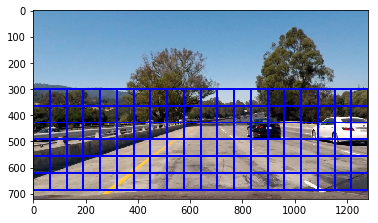

In [22]:
image = mpimg.imread('./examples/test1.jpg')
image=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[300, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Parameters tunning

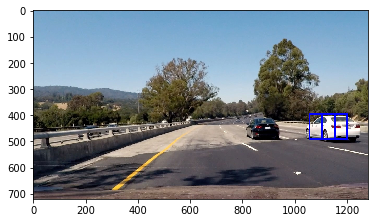

In [23]:
image = mpimg.imread('./examples/test4.jpg')
image=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

draw_image = np.copy(image)
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


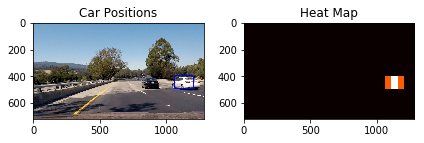

In [24]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives 
# Not needed, good classifier
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


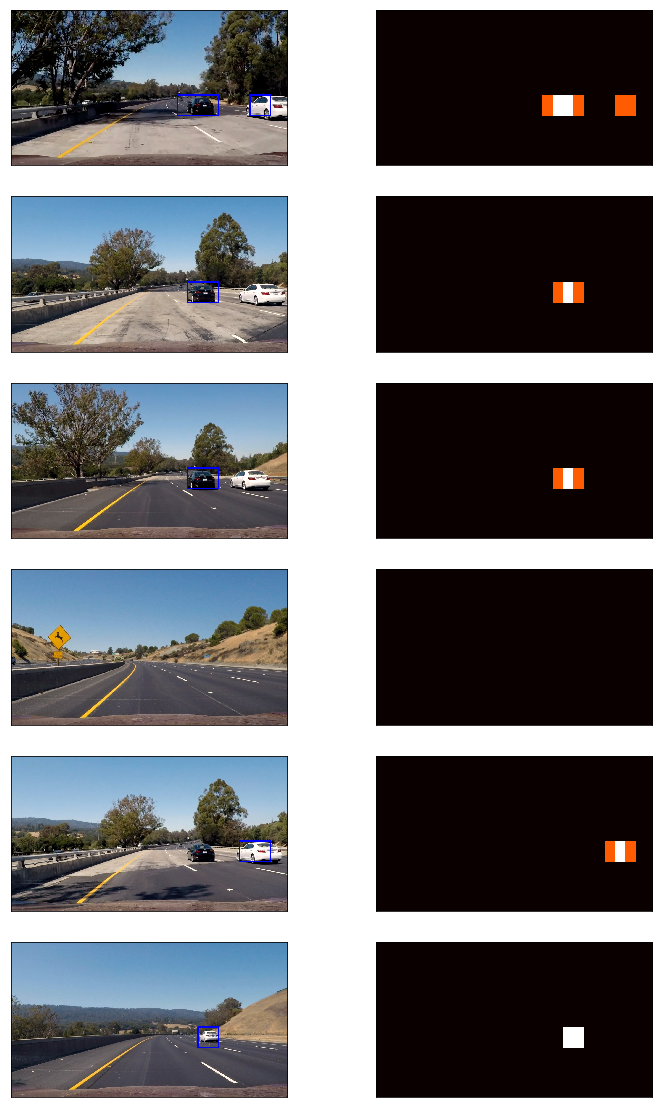

In [28]:
test_dir = os.getcwd() + '/test_images'
fig = plt.figure(figsize=(12, 20))
elem = 1
for file in os.listdir(test_dir):
    if not fnmatch.fnmatch(file, "*.jpg"):
        continue
    filename = os.path.join(test_dir, file)
    image = mpimg.imread(filename)
    image=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

        # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    ax = fig.add_subplot(6, 2, elem)
    ax.imshow(draw_img)
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    elem += 1
    ax = fig.add_subplot(6, 2, elem)
    ax.imshow(heatmap, cmap='hot')
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    elem += 1

## Test on video
---

In [31]:
output_video = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_processor = Processor()
processed_clip = clip1.fl_image(video_processor.process_frame) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [22:42<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 39min 16s, sys: 5h 21min 26s, total: 6h 43s
Wall time: 22min 42s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Extra: Opencv Haar Classifier
---

In [262]:
cascade_src = 'cars.xml'
video_src = 'project_video.mp4'
#video_src = 'dataset/video2.avi'

cap = cv2.VideoCapture(video_src)
car_cascade = cv2.CascadeClassifier(cascade_src)

while True:
    v=ProcessorHaar()
    ret, img = cap.read()
    if (type(img) == type(None)):
        break
    img=cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    cars = car_cascade.detectMultiScale(gray,scaleFactor = 1.1 ,minNeighbors = 2,
            minSize = (130, 130),maxSize = (330, 330), flags = cv2.CASCADE_SCALE_IMAGE)
    res=v.process_frame(cars,img)
    for (x,y,w,h) in cars:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)      
    
    cv2.imshow('video', res)
    
    if cv2.waitKey(33) == 27:
        break

cv2.destroyAllWindows()